# Mercado Libre Codex
**Author:** Samuel Machado
<br>**Date:** May, 2024

### **Briefing** 

**Description:**
In the context of Mercadolibre's Marketplace an algorithm is needed to predict if an item listed in the markeplace is new or used.

Your tasks involve the data analysis, designing, processing and modeling of a machine learning solution 
to predict if an item is new or used and then evaluate the model over held-out test data.

To assist in that task a dataset is provided in `MLA_100k_checked_v3.jsonlines` and a function to read that dataset in `build_dataset`.

For the evaluation, you will use the accuracy metric in order to get a result of 0.86 as minimum. 
Additionally, you will have to choose an appropiate secondary metric and also elaborate an argument on why that metric was chosen.

The deliverables are:
- The file, including all the code needed to define and evaluate a model.
- A document with an explanation on the criteria applied to choose the features, the proposed secondary metric and the performance achieved on that metrics. Optionally, you can deliver an EDA analysis with other formart like .ipynb

---

## **Wrap up**

Para solucionar este desafio, desenvolvi um modelo de **classificação** utilizando a metodologia **CRISP-DM**, em ciclos de aperfeiçoamento. Neste notebook, vou apresentar mais detalhadamente grande parte desse processo. Para a etapa de deploy, fiz a implementação do script no arquivo new_used.py conforme as instruções. Apesar dos cuidados com ambiente e a construção do pipeline, esta versão não pode ser considerada "produtiva" e seu output são as métricas de avaliação do modelo.

Sobre a métrica adicional, escolhi a **AUC ROC**, por se tratar de uma métrica que revela a capacidade do modelo de distinguir as classes do evento (new, used) independente dos thresholds, sendo inclusive uma boa métrica de escolha entre modelos. Vale destacar que foi estudada a métrica logloss, mas por necessitar de um estudo maior sobre o balanceamento dos dados para ponderá-la, ela não foi a escolhida no momento. 

Com essas duas métricas, **acurácia** e **AUC ROC** temos uma leitura sobre a qualidade do modelo e seu desempenho específico nesta aplicação. 

**Resumo dos resultados obtidos:**
- Modelo de classificação 
- Library selecionada: XGBoost
- Acurácia estimada: 89%
- AUC ROC estimado: 89%

## **Setup Environment**

### **Packages**

In [1]:
import subprocess
import sys

def install_packages(package_list):
    for package in package_list:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of packages
packages = [
    "pandas==2.1.4",
    "numpy==1.26.4",
    "scikit-learn==1.4.2",
    "xgboost==2.0.3",
    "sweetviz==2.3.1",
    "seaborn==0.13.2",
    "matplotlib==3.7.5",
    "pycaret==3.3.2",
    "hyperopt==0.2.7",
]

# Call the function with the list of packages
install_packages(packages)

### **Libraries**

In [2]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, TargetEncoder
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from pycaret.classification import setup, compare_models
from hyperopt import fmin, tpe, hp, STATUS_OK
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import numpy as np
import pandas as pd
import json

pd.set_option('display.max_columns', None)

## **Data**

In [3]:
PATH = "MLA_100k_checked_v3.jsonlines"

with open(PATH) as file:
    data = [json.loads(x) for x in file]

## **EDA**

### **Overview**
Some features are lists of dictionaries and should be extracted (normalized), such as <code>shipping</code>.

For features that are lists of values or multiple dictionaries, like <code>non_mercado_pago_payment_methods</code>, it's essential to separate them. This separation is a crucial step in generating an initial AutoEDA view. The separated lists should be analyzed individually, as exploding could duplicate events.

It's worth noting that some categorical features and dates are represented as numbers, such as <code>seller_id</code> and <code>start_time</code>. Understanding their correct usage during modeling is essential to avoid potential errors.

In [4]:
# print lengh and first lines
print("Length of data: ", len(data))
pd.DataFrame(data).head(3)

Length of data:  100000


,seller_address,warranty,sub_status,condition,deal_ids,base_price,shipping,non_mercado_pago_payment_methods,seller_id,variations,site_id,listing_type_id,price,attributes,buying_mode,tags,listing_source,parent_item_id,coverage_areas,category_id,descriptions,last_updated,international_delivery_mode,pictures,id,official_store_id,differential_pricing,accepts_mercadopago,original_price,currency_id,thumbnail,title,automatic_relist,date_created,secure_thumbnail,stop_time,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,sold_quantity,available_quantity
0,"{'country': {'name': 'Argentina', 'id': 'AR'},...",None,[],new,[],80.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8208882349,[],MLA,bronze,80.0,[],buy_it_now,[dragged_bids_and_visits],,MLA6553902747,[],MLA126406,[{'id': 'MLA4695330653-912855983'}],2015-09-05T20:42:58.000Z,none,"[{'size': '500x375', 'secure_url': 'https://a2...",MLA4695330653,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/5386-MLA469533065...,Auriculares Samsung Originales Manos Libres Ca...,False,2015-09-05T20:42:53.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1446669773000,active,None,NaN,None,1,1441485773000,http://articulo.mercadolibre.com.ar/MLA4695330...,0,1
1,"{'country': {'name': 'Argentina', 'id': 'AR'},...",NUESTRA REPUTACION,[],used,[],2650.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8141699488,[],MLA,silver,2650.0,[],buy_it_now,[],,MLA7727150374,[],MLA10267,[{'id': 'MLA7160447179-930764806'}],2015-09-26T18:08:34.000Z,none,"[{'size': '499x334', 'secure_url': 'https://a2...",MLA7160447179,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/23223-MLA71604471...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,2015-09-26T18:08:30.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1448474910000,active,None,NaN,None,1,1443290910000,http://articulo.mercadolibre.com.ar/MLA7160447...,0,1
2,"{'country': {'name': 'Argentina', 'id': 'AR'},...",None,[],used,[],60.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8386096505,[],MLA,bronze,60.0,[],buy_it_now,[dragged_bids_and_visits],,MLA6561247998,[],MLA1227,[{'id': 'MLA7367189936-916478256'}],2015-09-09T23:57:10.000Z,none,"[{'size': '375x500', 'secure_url': 'https://a2...",MLA7367189936,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/22076-MLA73671899...,"Antigua Revista Billiken, N° 1826, Año 1954",False,2015-09-09T23:57:07.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1447027027000,active,None,NaN,None,1,1441843027000,http://articulo.mercadolibre.com.ar/MLA7367189...,0,1


In [5]:
# normalize
source = pd.json_normalize(data)

# print lengh and first lines
print ("Lenght of source: ", len(source))
source.head(3)

Lenght of source:  100000


,warranty,sub_status,condition,deal_ids,base_price,non_mercado_pago_payment_methods,seller_id,variations,site_id,listing_type_id,price,attributes,buying_mode,tags,listing_source,parent_item_id,coverage_areas,category_id,descriptions,last_updated,international_delivery_mode,pictures,id,official_store_id,differential_pricing,accepts_mercadopago,original_price,currency_id,thumbnail,title,automatic_relist,date_created,secure_thumbnail,stop_time,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,sold_quantity,available_quantity,seller_address.country.name,seller_address.country.id,seller_address.state.name,seller_address.state.id,seller_address.city.name,seller_address.city.id,shipping.local_pick_up,shipping.methods,shipping.tags,shipping.free_shipping,shipping.mode,shipping.dimensions,shipping.free_methods
0,None,[],new,[],80.0,"[{'description': 'Transferencia bancaria', 'id...",8208882349,[],MLA,bronze,80.0,[],buy_it_now,[dragged_bids_and_visits],,MLA6553902747,[],MLA126406,[{'id': 'MLA4695330653-912855983'}],2015-09-05T20:42:58.000Z,none,"[{'size': '500x375', 'secure_url': 'https://a2...",MLA4695330653,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/5386-MLA469533065...,Auriculares Samsung Originales Manos Libres Ca...,False,2015-09-05T20:42:53.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1446669773000,active,None,NaN,None,1,1441485773000,http://articulo.mercadolibre.com.ar/MLA4695330...,0,1,Argentina,AR,Capital Federal,AR-C,San Cristóbal,TUxBQlNBTjkwNTZa,True,[],[],False,not_specified,None,NaN
1,NUESTRA REPUTACION,[],used,[],2650.0,"[{'description': 'Transferencia bancaria', 'id...",8141699488,[],MLA,silver,2650.0,[],buy_it_now,[],,MLA7727150374,[],MLA10267,[{'id': 'MLA7160447179-930764806'}],2015-09-26T18:08:34.000Z,none,"[{'size': '499x334', 'secure_url': 'https://a2...",MLA7160447179,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/23223-MLA71604471...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,2015-09-26T18:08:30.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1448474910000,active,None,NaN,None,1,1443290910000,http://articulo.mercadolibre.com.ar/MLA7160447...,0,1,Argentina,AR,Capital Federal,AR-C,Buenos Aires,,True,[],[],False,me2,None,NaN
2,None,[],used,[],60.0,"[{'description': 'Transferencia bancaria', 'id...",8386096505,[],MLA,bronze,60.0,[],buy_it_now,[dragged_bids_and_visits],,MLA6561247998,[],MLA1227,[{'id': 'MLA7367189936-916478256'}],2015-09-09T23:57:10.000Z,none,"[{'size': '375x500', 'secure_url': 'https://a2...",MLA7367189936,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/22076-MLA73671899...,"Antigua Revista Billiken, N° 1826, Año 1954",False,2015-09-09T23:57:07.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,1447027027000,active,None,NaN,None,1,1441843027000,http://articulo.mercadolibre.com.ar/MLA7367189...,0,1,Argentina,AR,Capital Federal,AR-C,Boedo,TUxBQkJPRTQ0OTRa,True,[],[],False,me2,None,NaN


#### Target
**PK & Target**
<br>The primary key (PK) of the table is the feature <code>id</code>, and the target is <code>condition</code>.
The target distribution indicates a slight imbalance in the dataset:

| Target | %   |
| ------ | --- |
| New    | 54% |
| Used   | 46% |

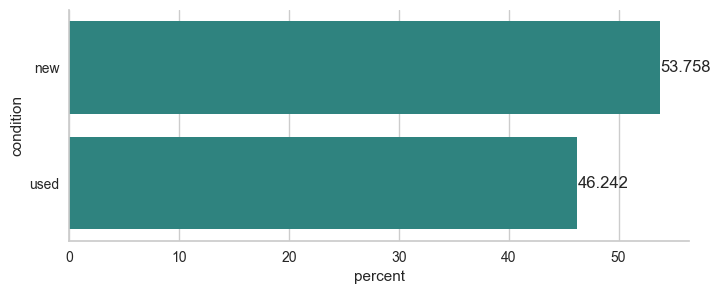

In [6]:
# target barplot
plt.figure(figsize=(8, 3))

ax = sns.countplot(source, y="condition", color="#21918c", stat="percent")

for i in ax.containers:
    ax.bar_label(i,)

sns.despine()

plt.show()

### **Drop columns**
<br>**Drop Columns**
<br>Below is the list of features to be ignored with justifications. Lists with only one label, or almost all unique, are irrelevant in the model construction, considering the distribution of the target variable.

| Criterion | Columns  |
| --------- | -------- |
| Missing   | 'coverage_areas', 'shipping.methods', 'subtitle', 'differential_pricing', 'catalog_product_id', 'shipping.dimensions', 'shipping.tags', 'original_price', 'deal_ids', 'official_store_id', 'sub_status', 'video_id', 'shipping.free_methods', 'variations', 'attributes' |
| Uniques   | parent_item_id (all not null values are distinct), thumbnail, permalink | 
| Equals    | site_id, international_delivery_mode, title (99%, mas poderia passar um NLP aqui como evolução), secure_thumbnail (99%), seller_address.country.name (99% ,ARG and empty), seller_address.country.id (99% ,ARG and empty) | 
| Redundant | seller_address.country.name e seller_address.country.id (drop), seller_address.state.name e seller_address.state.id (drop), seller_address.city.name e seller_address.city.id (drop) |

In [7]:
def missing_percentage(df):
    total = df.shape[0]
    missing_data = df.map(lambda x: x == [] if isinstance(x, list) else pd.isnull(x)).sum().sort_values(ascending=False)
    missing_percent = (missing_data / total) * 100
    missing_df = pd.DataFrame({'Missing Count': missing_data, '% of Total Values': missing_percent})
    return missing_df

missing_df = missing_percentage(source)

# features with more than 85% missing values
missing_list = missing_df[missing_df['% of Total Values'] > 85].index.tolist()

print("Features with more than 85% missing values: ", missing_list)
missing_df.loc[missing_df['% of Total Values'] > 0]

Features with more than 85% missing values:  ['coverage_areas', 'shipping.methods', 'subtitle', 'differential_pricing', 'catalog_product_id', 'shipping.dimensions', 'shipping.tags', 'original_price', 'deal_ids', 'official_store_id', 'sub_status', 'video_id', 'shipping.free_methods', 'variations', 'attributes']


,Missing Count,% of Total Values
coverage_areas,100000,100.000
shipping.methods,100000,100.000
subtitle,100000,100.000
differential_pricing,100000,100.000
catalog_product_id,99989,99.989
shipping.dimensions,99977,99.977
shipping.tags,99931,99.931
original_price,99857,99.857
deal_ids,99760,99.760
official_store_id,99182,99.182


### **List type features**
To generate the AutoEDA, we will temporarily exclude list-type variables.

In [8]:
# check features with list type
lst_cols = []
for col in source.columns:
    if source[col].apply(type).eq(list).any():
        lst_cols.append(col)
        
# drop features with list type
print("Features with list type: ", lst_cols)
df_bronze = source.drop(columns=lst_cols)

Features with list type:  ['sub_status', 'deal_ids', 'non_mercado_pago_payment_methods', 'variations', 'attributes', 'tags', 'coverage_areas', 'descriptions', 'pictures', 'shipping.methods', 'shipping.tags', 'shipping.free_methods']


### **Unique values**
Identify the categorical features with high cardinality or a single category.

In [9]:
def count_unique_values(df):
    total = df.shape[0]
    unique_counts = df.apply(lambda x: len(x.unique()))
    unique_percent = (unique_counts / total) * 100

    unique_df = pd.DataFrame({'Feature Name': unique_counts.index, 'Count': unique_counts.values, '% of Total Values': unique_percent.values})
    
    # Sort by '% of Total Values' in descending order
    unique_df = unique_df.sort_values(by='% of Total Values', ascending=False)
    
    return unique_df

unique_df = count_unique_values(df_bronze)

# features with more than 85% missing values
unique_list = unique_df.loc[
    (unique_df['% of Total Values'] > 95) |
    (unique_df['Count'] == 1)
    ]["Feature Name"].tolist()

print("Features with more than 85% unique values: ", unique_list)
unique_df

Features with more than 85% unique values:  ['permalink', 'id', 'thumbnail', 'secure_thumbnail', 'title', 'last_updated', 'international_delivery_mode', 'listing_source', 'site_id', 'subtitle', 'differential_pricing']


,Feature Name,Count,% of Total Values
31,permalink,100000,100.000
13,id,100000,100.000
19,thumbnail,99172,99.172
23,secure_thumbnail,99172,99.172
20,title,98823,98.823
11,last_updated,95124,95.124
22,date_created,87075,87.075
30,start_time,86628,86.628
24,stop_time,86165,86.165
9,parent_item_id,76990,76.990


### **2nd drop columns**
The date features were also removed in this first version due to the need to understand the meaning of the columns start_time and stop_time. However, it is worth considering including a variable representing the time variation if it makes sense.

In [10]:
# create a list of date columns 
date_lst =["last_update", "date_created", "stop_time", "start_time",]

equivalent_lst = ["seller_address.city.id", "seller_address.state.id", "seller_address.country.id"]

exceptions_lst = ["parent_item_id", "seller_address.country.name"]

# concat all lists
drop_lst = list(set(missing_list + unique_list + date_lst + equivalent_lst + exceptions_lst))

# drop columns
cols_to_drop = set(drop_lst).intersection(df_bronze.columns)
df_silver = df_bronze.drop(cols_to_drop, axis=1)
supported_cols = df_silver.columns.tolist()

print("Supported columns ({}): {}".format(len(supported_cols), supported_cols))


Supported columns (20): ['warranty', 'condition', 'base_price', 'seller_id', 'listing_type_id', 'price', 'buying_mode', 'category_id', 'accepts_mercadopago', 'currency_id', 'automatic_relist', 'status', 'initial_quantity', 'sold_quantity', 'available_quantity', 'seller_address.state.name', 'seller_address.city.name', 'shipping.local_pick_up', 'shipping.free_shipping', 'shipping.mode']


### **Features Type**

| Type         | columns |
| ------------ | ------- |
| Date         | last_update, date_created, stop_time, start_time |
| Categorical  | seller_id, site_id, listing_type_id, buying_mode, parent_item_id, category_id, official_store_id, currency_id, thumbnail, title, secure_thumbnail, status, video_id, catalog_product_id, permalink, seller_address.country.name, seller_address.country.id, seller_address.state.name, seller_address.state.id, seller_address.city.name, seller_address.city.id, shipping.mode, accepts_mercadopago (bool), automatic_relist (bool), shipping.local_pick_up (bool), shipping.free_shipping (bool) |
| Numerical    | base_price, price, original_price, initial_quantity, sold_quantity, available_quantity |
| List         | 'sub_status', 'deal_ids', 'non_mercado_pago_payment_methods', 'variations', 'attributes', 'tags', 'coverage_areas', 'descriptions', 'pictures', 'shipping.methods', 'shipping.tags', 'shipping.free_methods' |

_PS: Initially, list-typed features were removed to be analyzed separately._

In [11]:
categorical = [
    'warranty',
    'condition', 
    "listing_type_id",
    "buying_mode",
    "currency_id",
    "status",
    "seller_address.state.name",
    "shipping.mode",
    "category_id",
    "seller_id",
    "seller_address.city.name",
]

numerical = [
    "base_price",
    "price",
    "initial_quantity",
    'sold_quantity',
    'available_quantity',
]

boolean = [
    "accepts_mercadopago",
    "automatic_relist",
    "shipping.local_pick_up",
    "shipping.free_shipping",
]

# cast types
type_dict = {
    "to_cat": categorical,
    "to_num": numerical,
    "to_bool": boolean,
}

for key, items in type_dict.items():
    if key == "to_cat":
        # to object
        for col in items:
            df_silver[col] = df_silver[col].astype("object")

    elif key == "to_num":
        # to int
        for col in items:
            df_silver[col] = df_silver[col].astype("float64")
    elif key == "to_bool":
        # to int
        for col in items:
            df_silver[col] = df_silver[col].astype("bool")

### **AutoEDA**
<br>**Cardinality**

Three features have a high cardinality and may require modification during data preparation.
- category_id (11% - 10.9k)
- seller_id (36% - 35.9k)
- seller_address.city.name (4% - 3.6k)
Lastly, the report generated by AutoEDA includes correlation and association charts.

                                             |          | [  0%]   00:00 -> (? left)


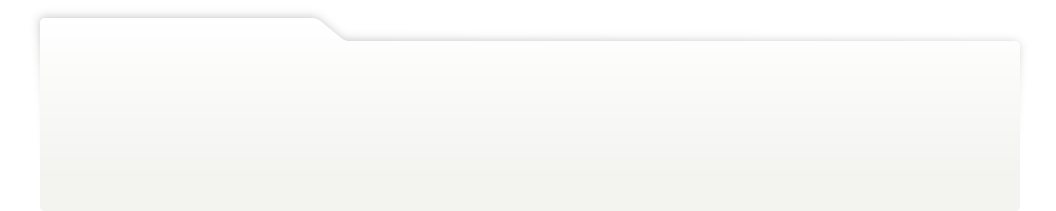
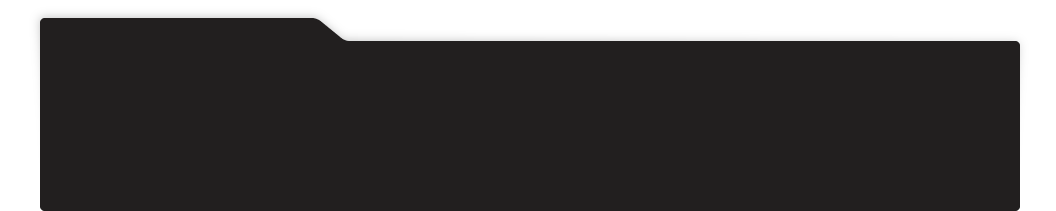
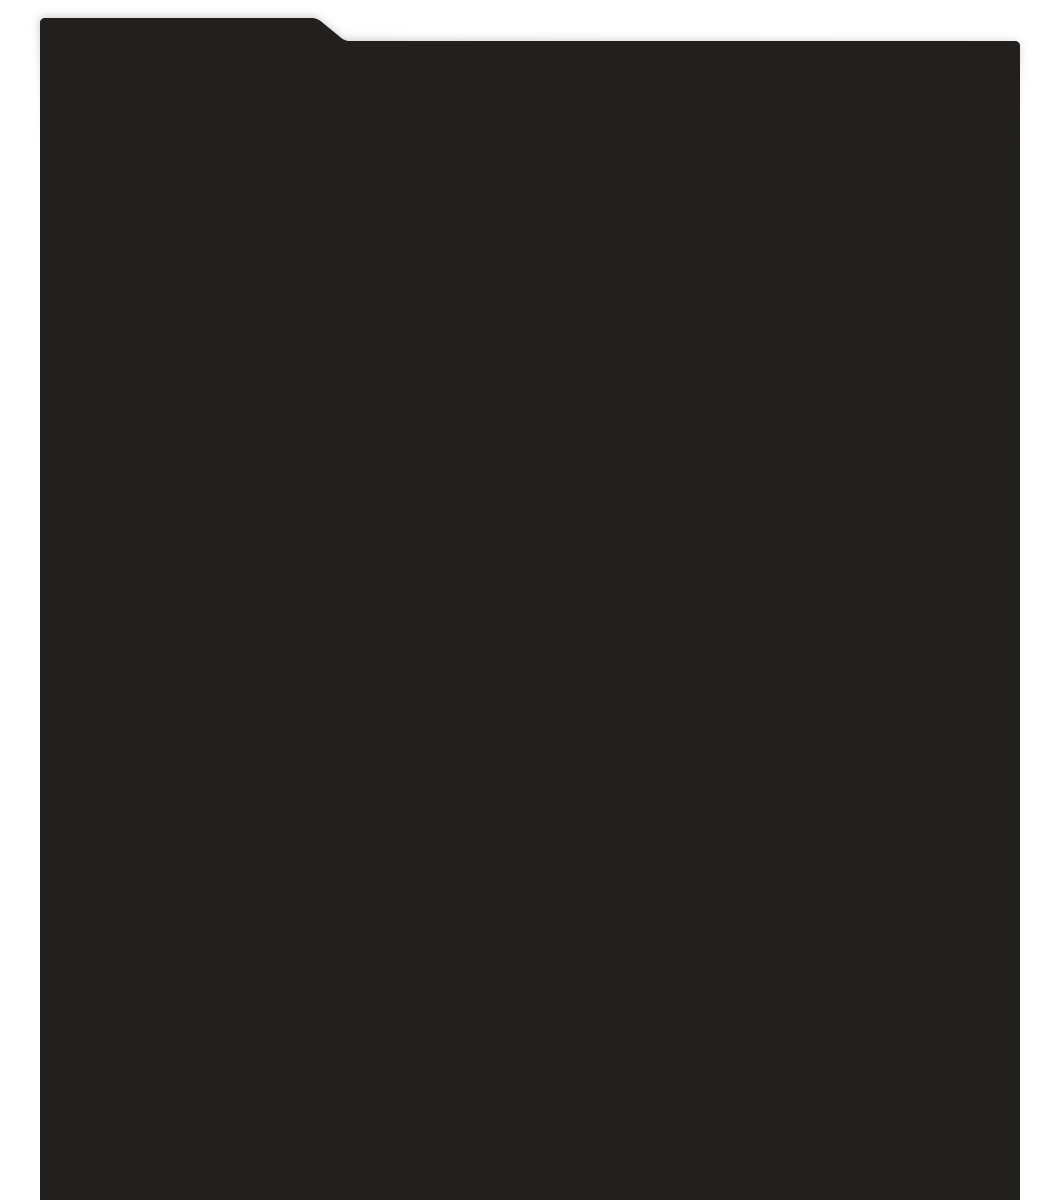
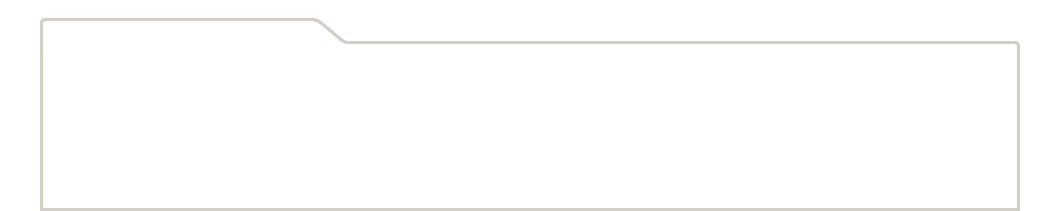
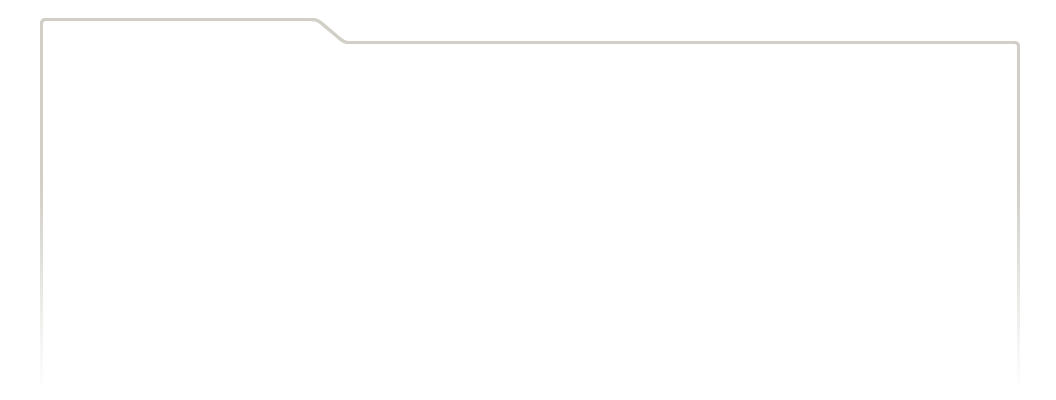
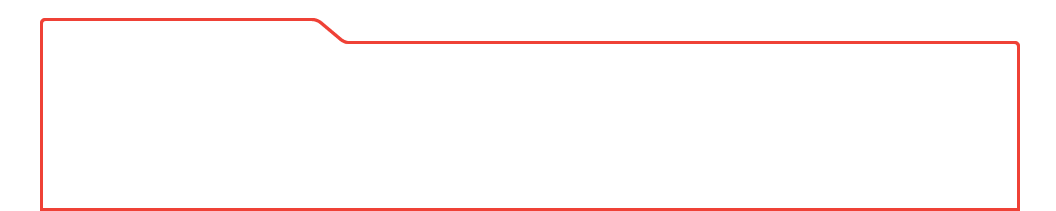
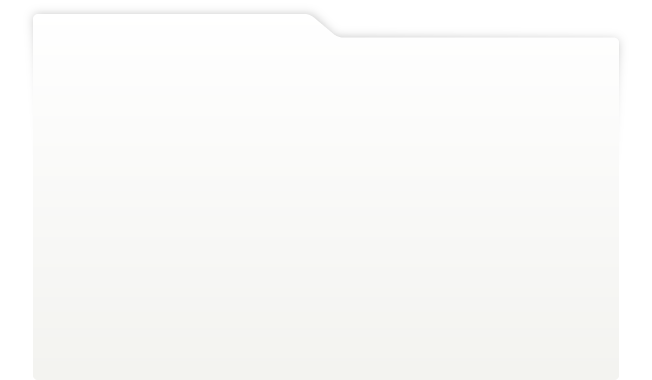
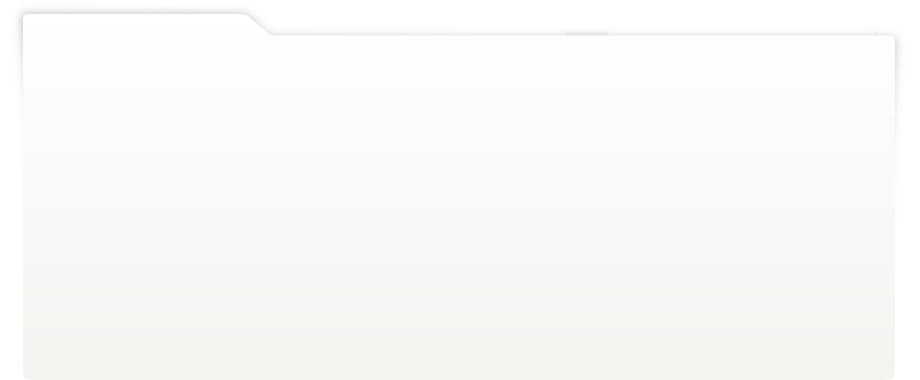
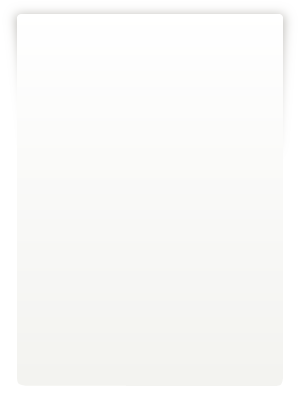
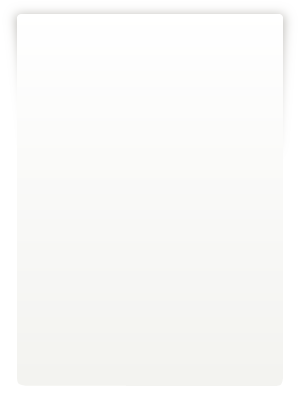
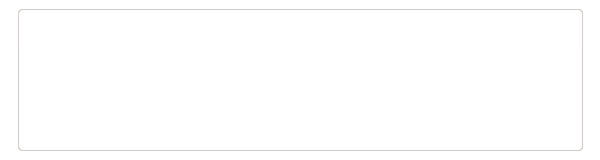
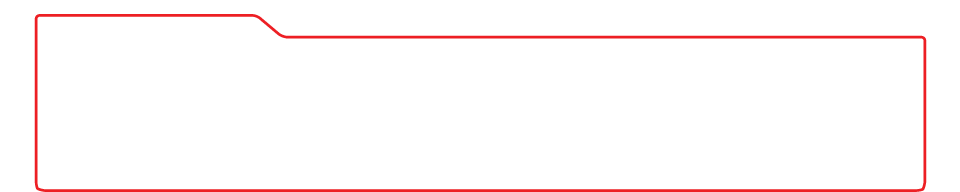
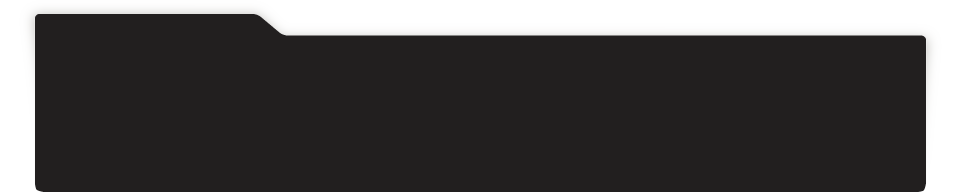
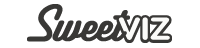
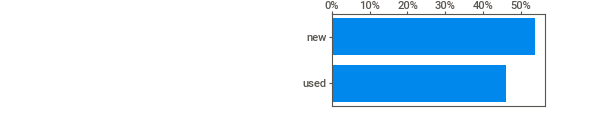
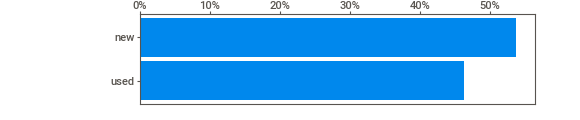
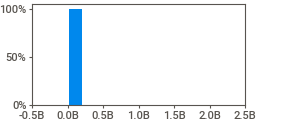
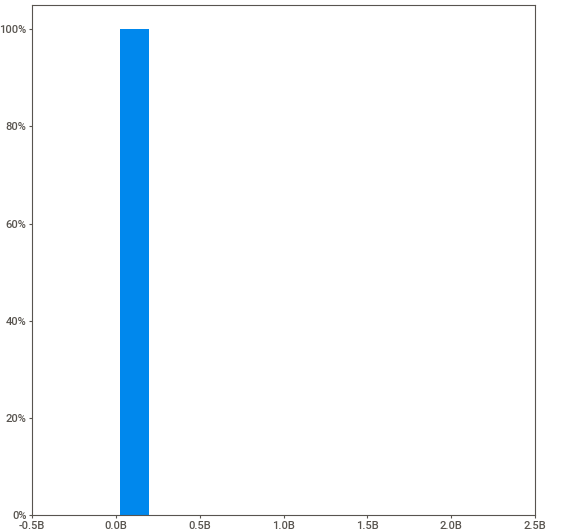
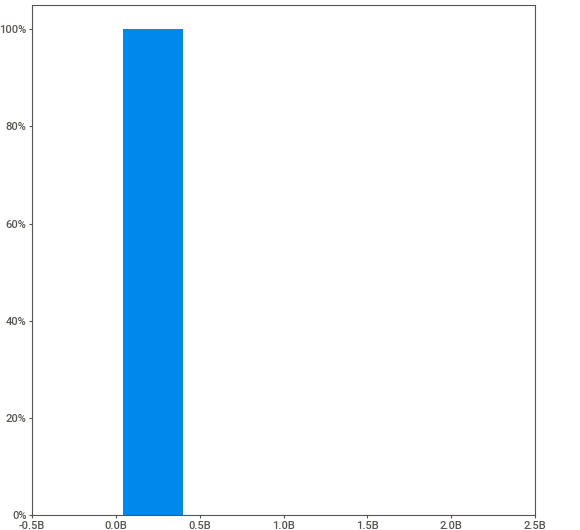
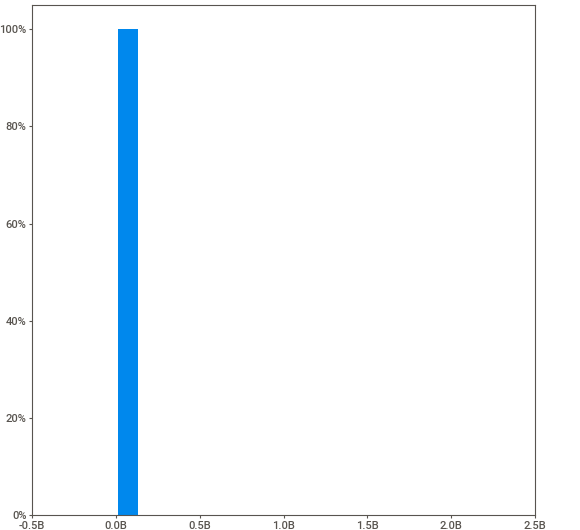
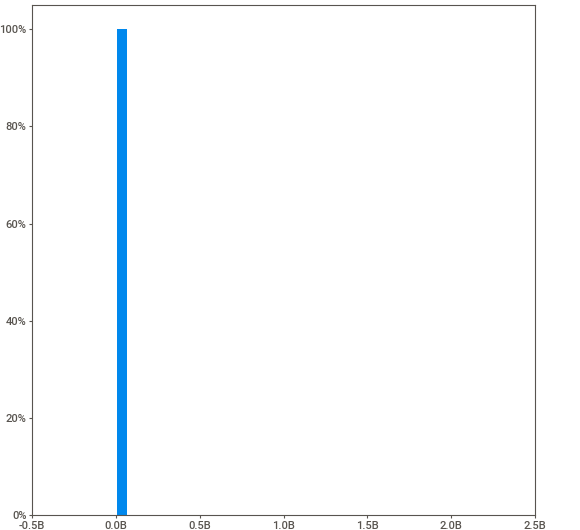
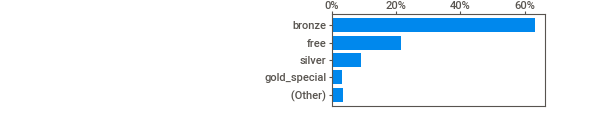
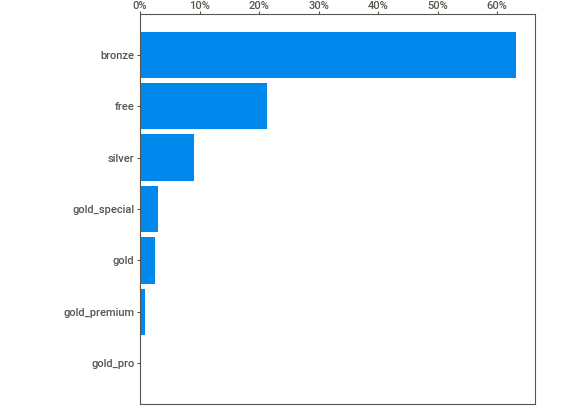
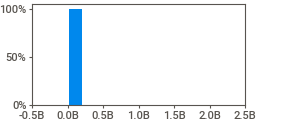
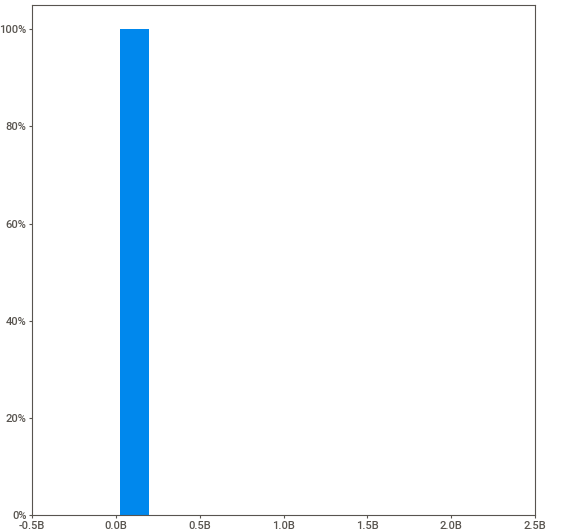
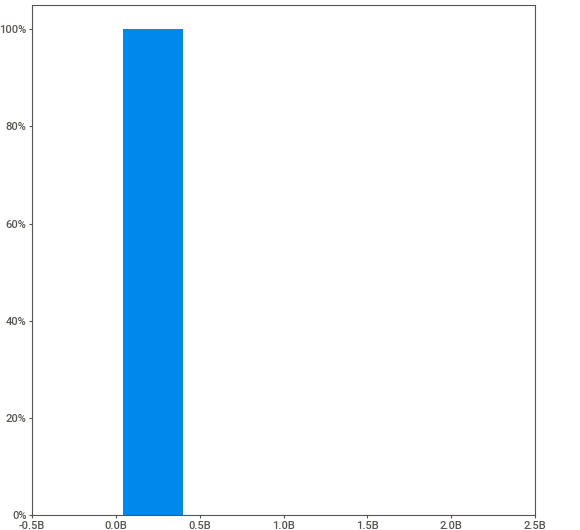
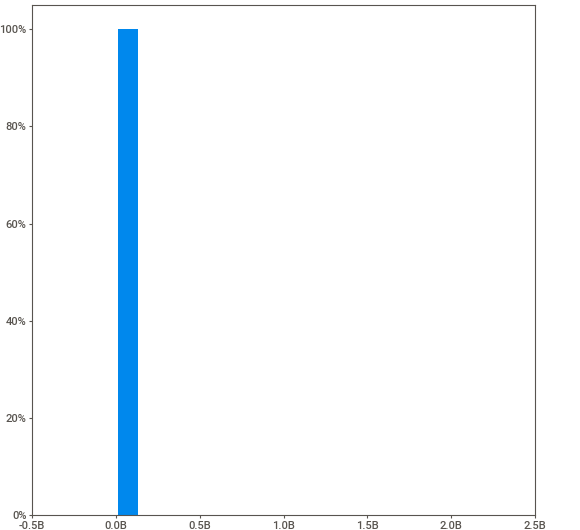
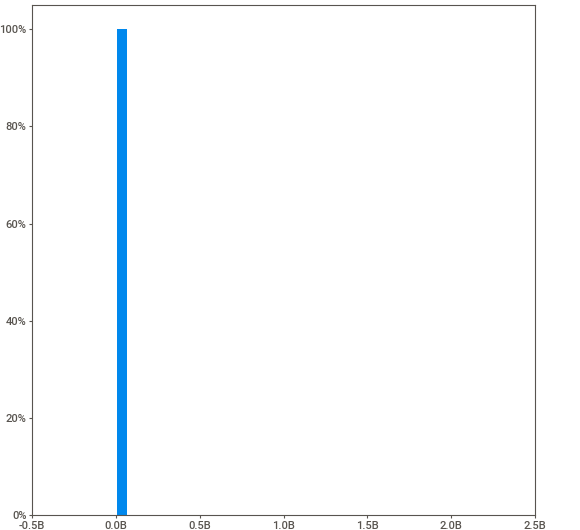
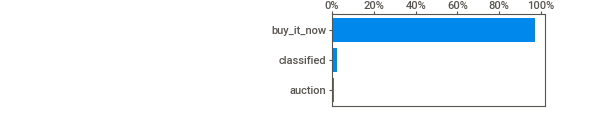
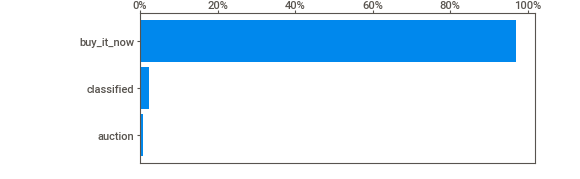
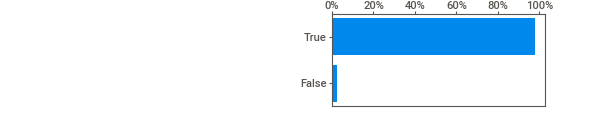
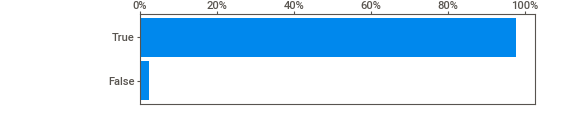
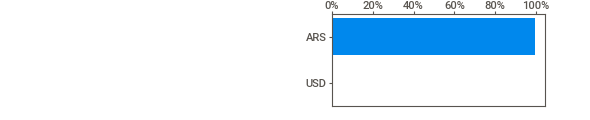
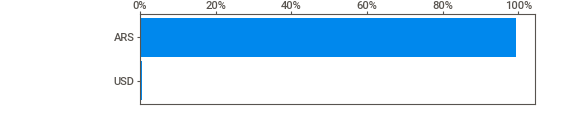
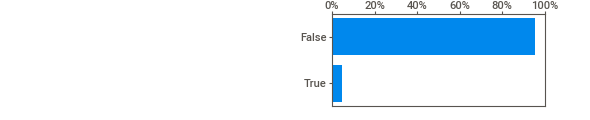
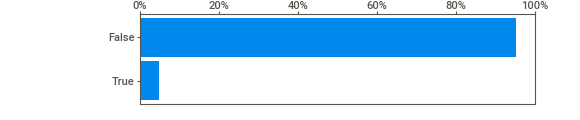
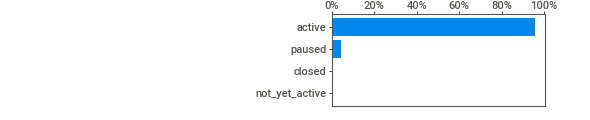
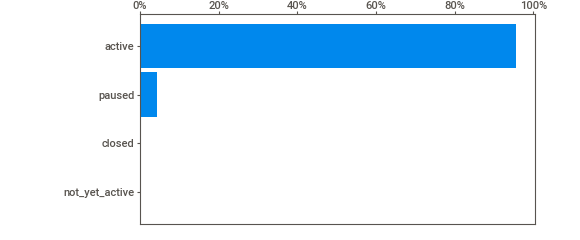
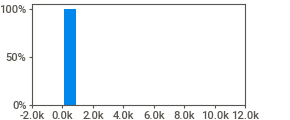
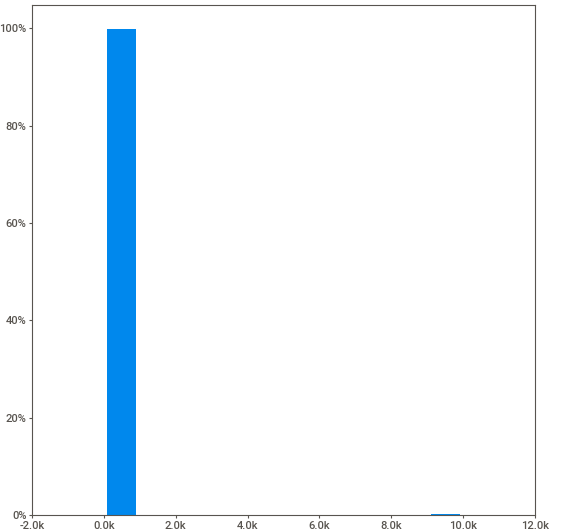
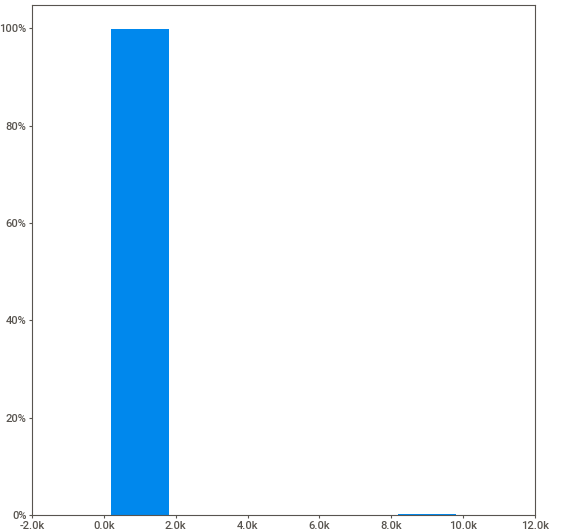
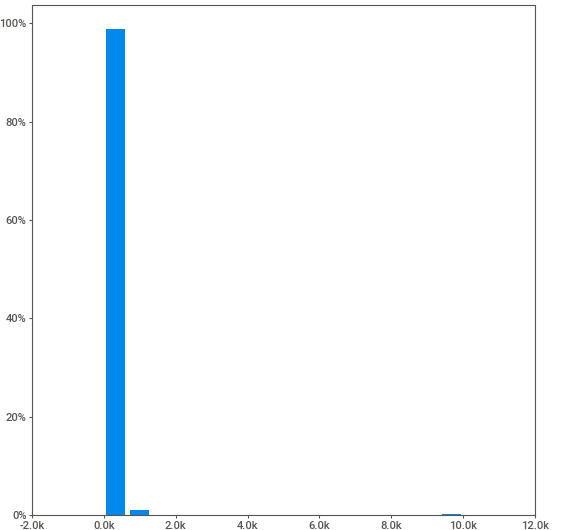
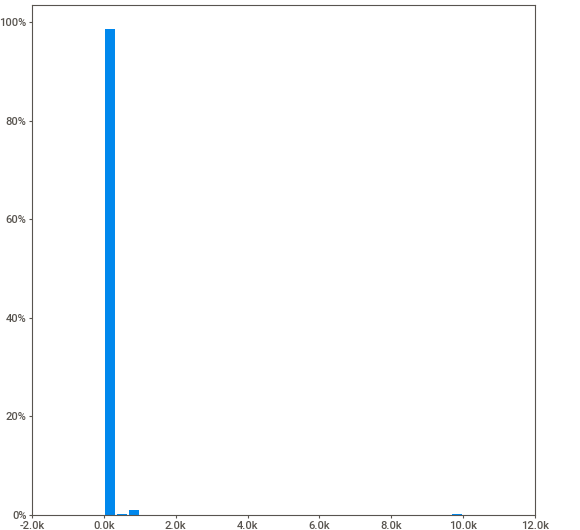
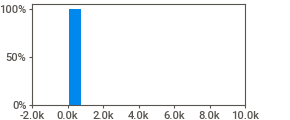
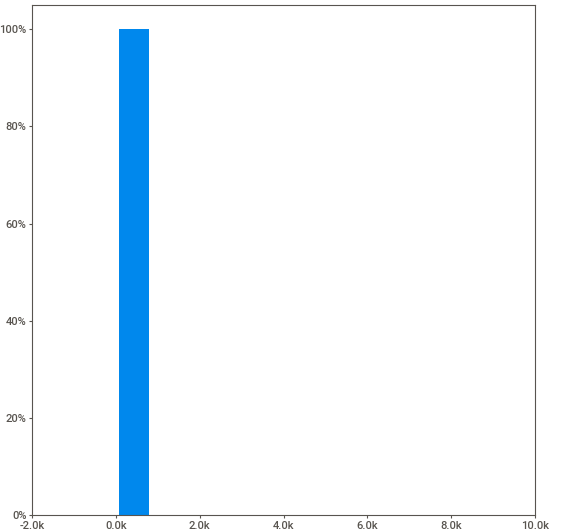
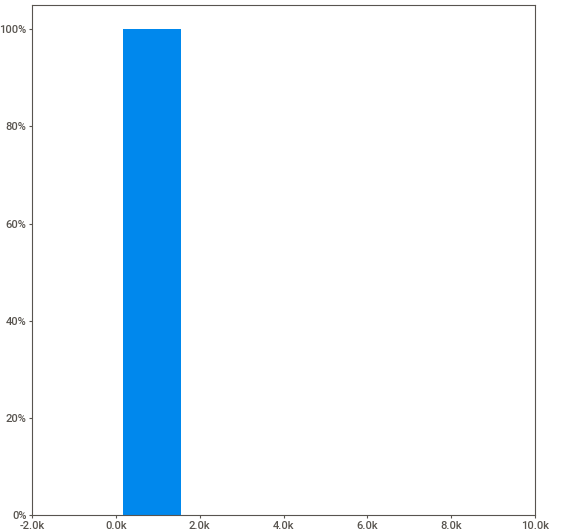
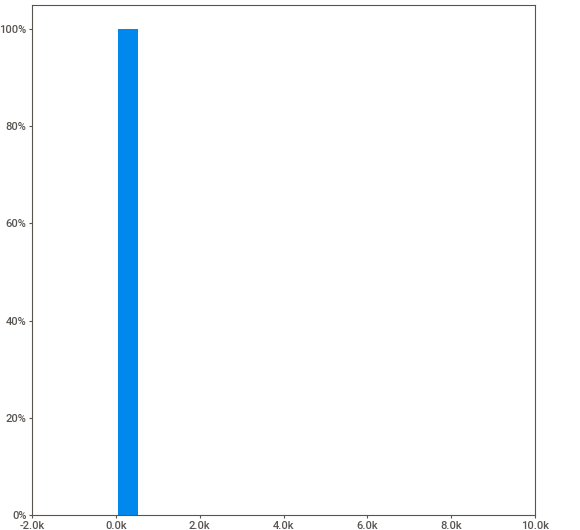
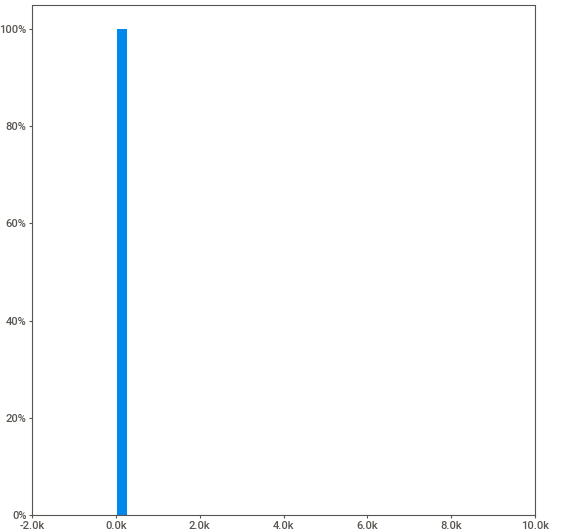
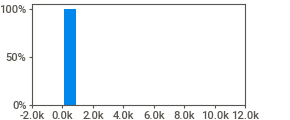
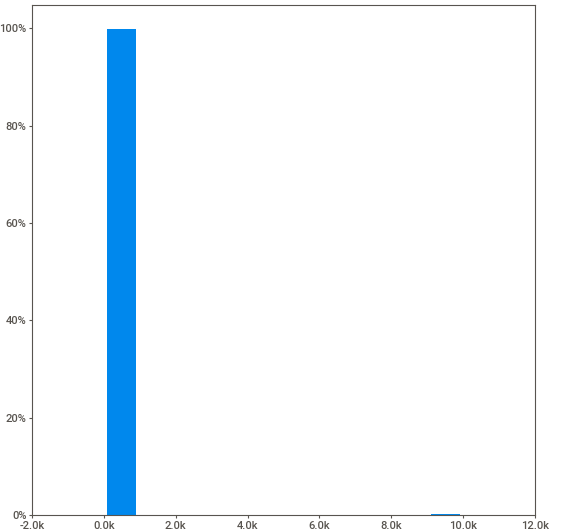
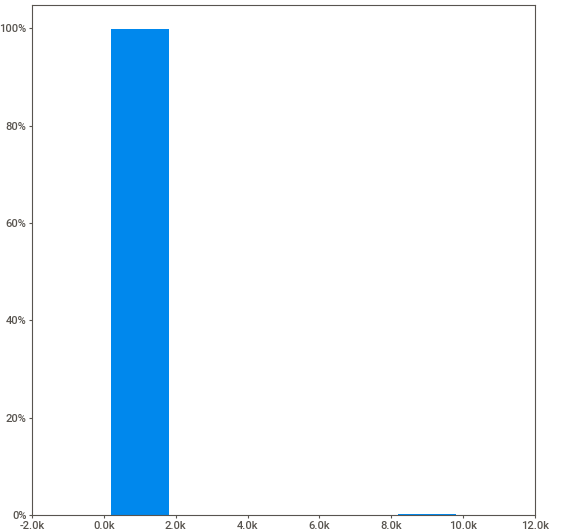
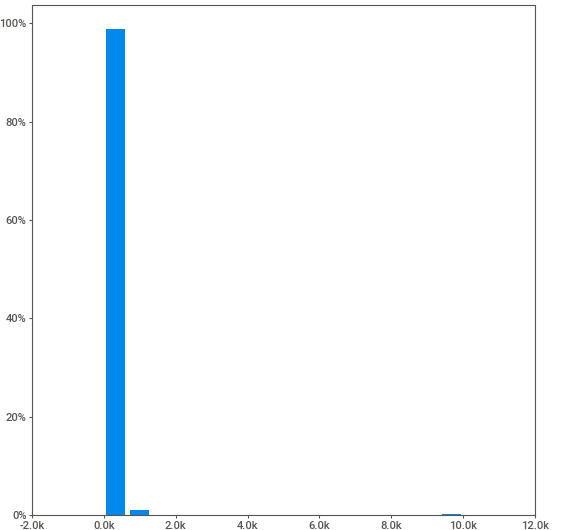
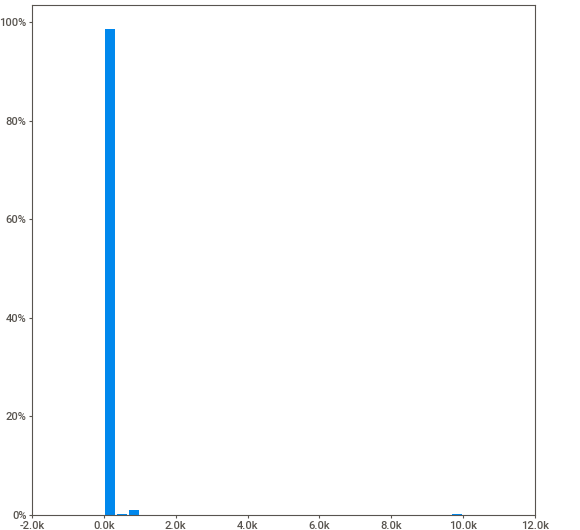
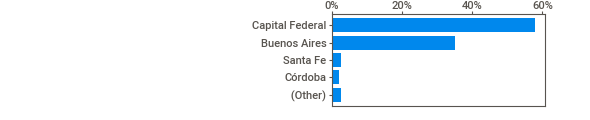
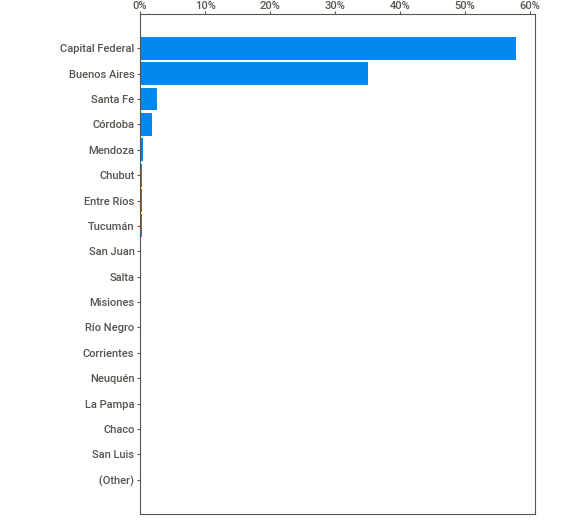
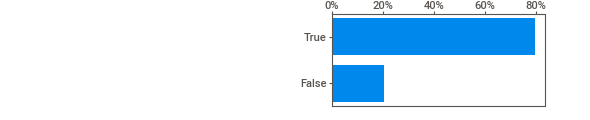
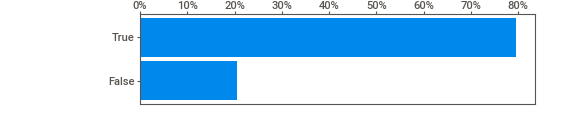
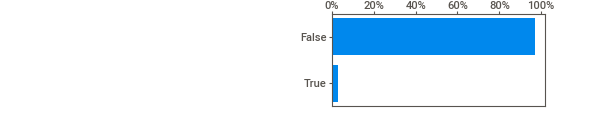
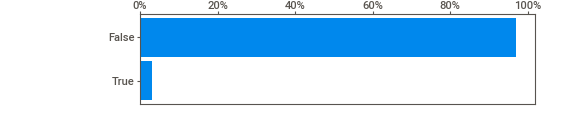
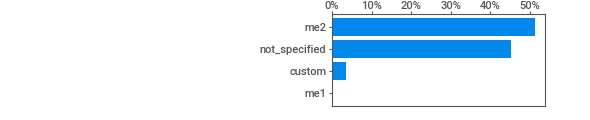
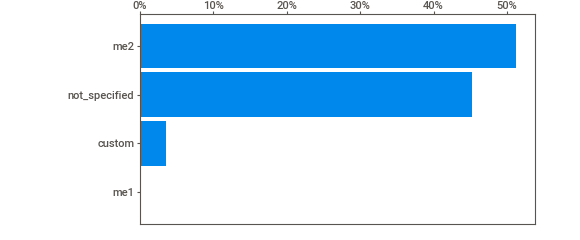
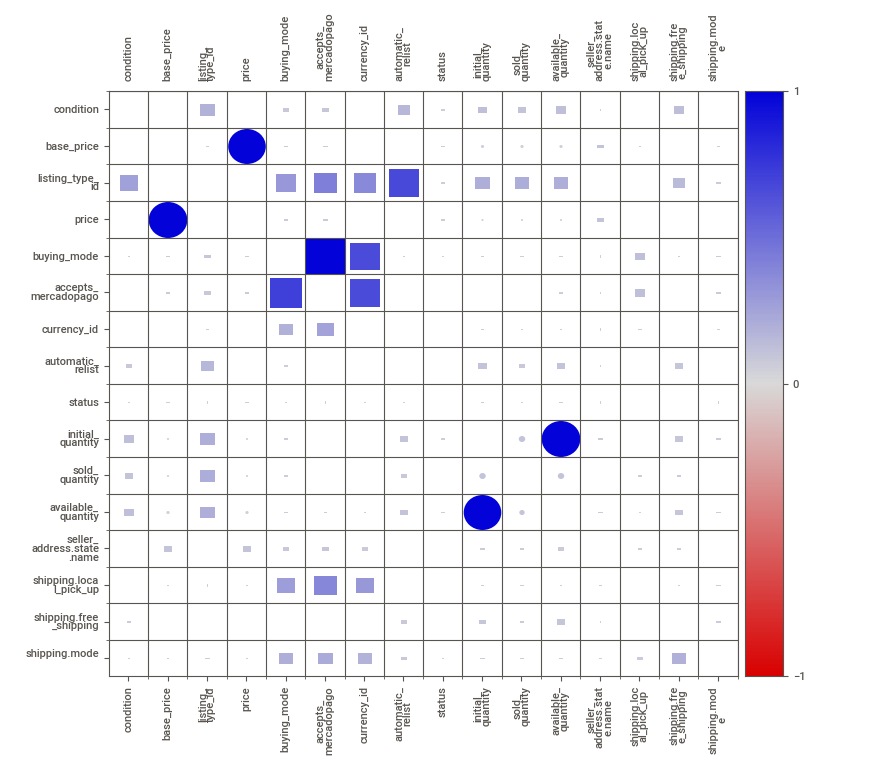
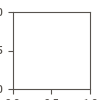

In [12]:
# create and display the report
report = sv.analyze(df_silver)
report.show_notebook(layout='vertical')

### **Numerical**
When examining the numerical features, several observations can be made:
1. High multicollinearity between two pairs of variables:
- "base_price" and "price"
- "initial_quantity" and "available_quantity"
Actions: Although not necessarily causing an issue for the model, it impacts its interpretability. Therefore, the variables "base_price" and "initial_quantity" will be excluded. <br><br>
2. The distributions of quantity variables are considerably more asymmetric than those of price.
Actions:
- Normalization of quantity variables
- Standardization of price variables
- Creation of outlier flags (not implemented due to time limitations)
Finally, although prices are similar in both target categories, quantities show more distinct differences, with larger volumes for new products.

#### Multicolinearity (VIF)

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif(df, numeric_features, threshold):
    X = df[numeric_features]
    variables = list(range(X.shape[1]))
    dropped = True

    vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
            for ix in range(X.iloc[:, variables].shape[1])]

    vif_list = []
    for col, x in zip(X.columns, vif):
        maxloc = np.where(np.array(vif) == x)[0][0].astype(int)
        if x > threshold:
            label = "high"
        else:
            label = "low"
        vif_list.append(tuple([col, maxloc, x, label]))
    df = pd.DataFrame(data=vif_list,
                        columns=["column", "idx", "VIF", "label"])
    return df

vif(df=df_silver, numeric_features=numerical, threshold=5)

,column,idx,VIF,label
0,base_price,0,1.648312e+11,high
1,price,0,1.648312e+11,high
2,initial_quantity,2,1.356805e+04,high
3,sold_quantity,3,1.417378e+00,low
4,available_quantity,4,1.355923e+04,high


In [14]:
price_cols = ["price"]
qtd_cols = ['sold_quantity', 'available_quantity',]

# update numerical list
numerical = price_cols + qtd_cols
df_silver[numerical].describe()

,price,sold_quantity,available_quantity
count,1.000000e+05,100000.000000,100000.000000
mean,5.252433e+04,2.396990,34.842380
std,8.623127e+06,42.685077,420.808403
min,8.400000e-01,0.000000,1.000000
25%,9.000000e+01,0.000000,1.000000
50%,2.500000e+02,0.000000,1.000000
75%,8.000000e+02,0.000000,2.000000
max,2.222222e+09,8676.000000,9999.000000


#### Distributions

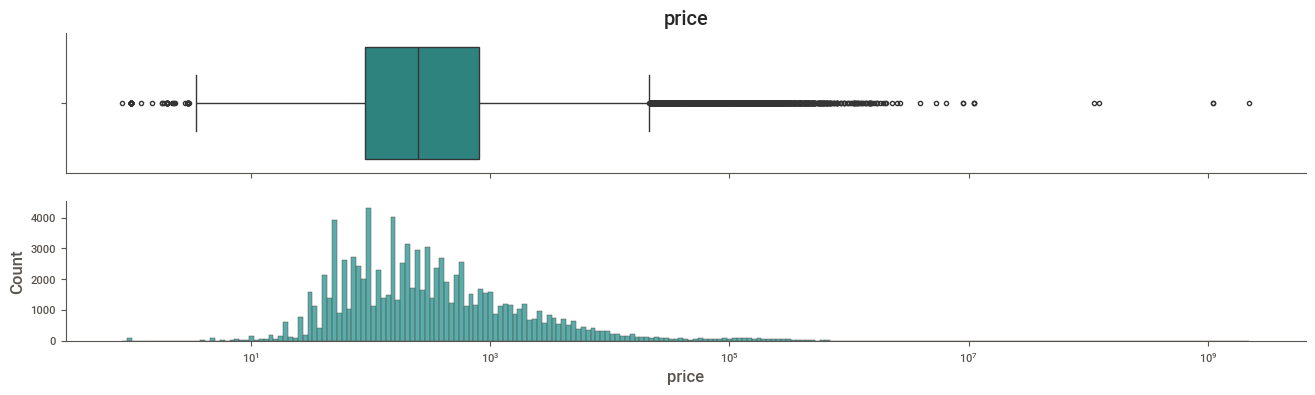

In [15]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(16,4))

data = df_silver["price"] + 1e-10
sns.boxplot(ax=axes[0], x=data, color="#21918c", log_scale=True)
axes[0].set_title("price")

sns.histplot(ax=axes[1], data=data, color="#21918c", log_scale=True)
    
sns.despine()
plt.show()

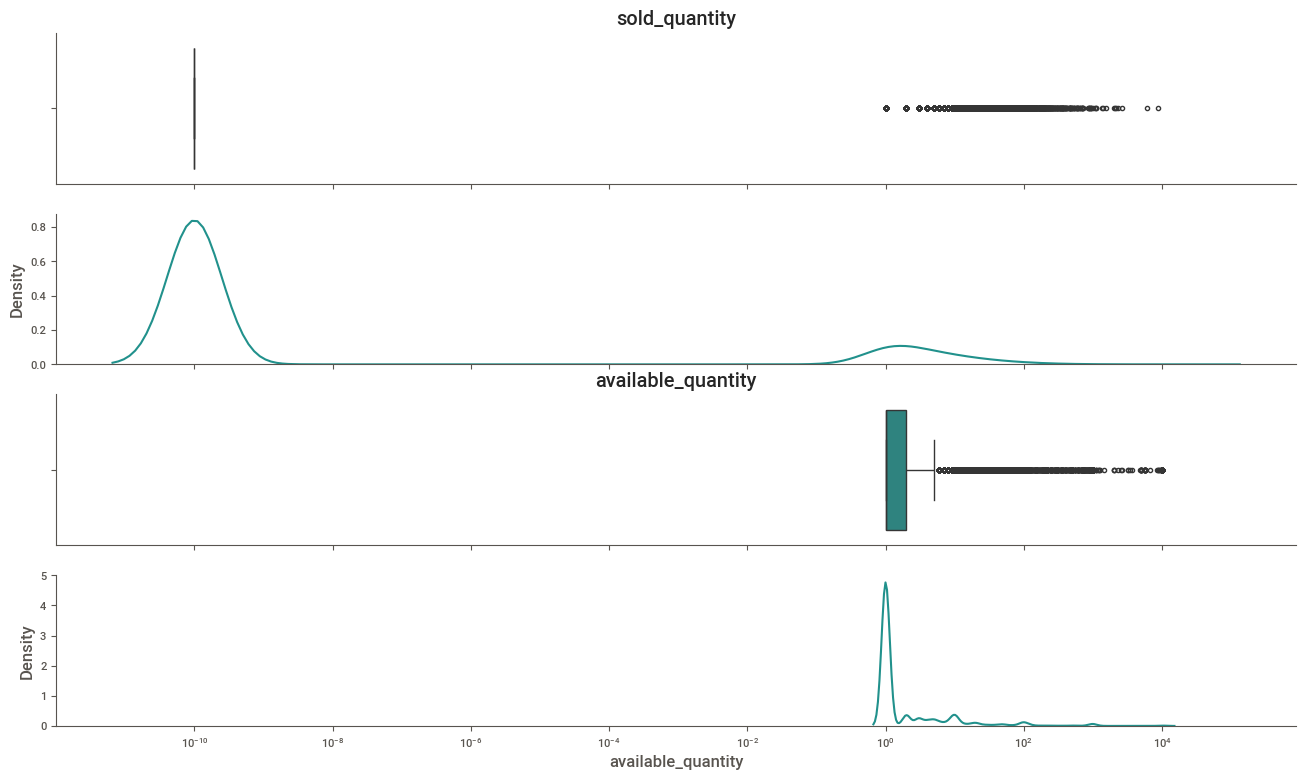

In [16]:
fig, axes = plt.subplots(2*len(qtd_cols), 1, sharex=True, figsize=(16,9))
#fig.suptitle('Price columns')

i = 0
for col in qtd_cols:
    # Add a small constant to ensure all values are positive
    data = df_silver[col] + 1e-10
    sns.boxplot(ax=axes[i], x=data, color="#21918c", log_scale=True)
    axes[i].set_title(col)
    i += 1
    sns.kdeplot(ax=axes[i], data=data, color="#21918c", log_scale=True)
    i += 1


sns.despine()
plt.show()

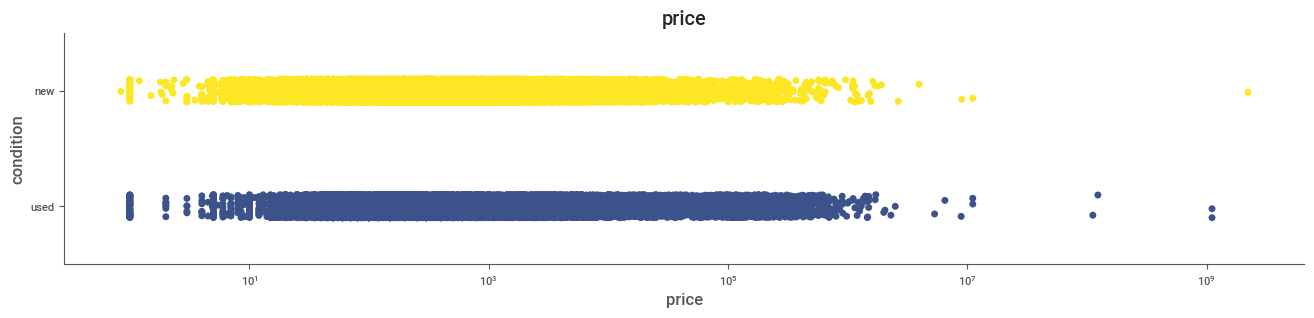

In [17]:
fig, axes = plt.subplots(1, len(price_cols), sharex=True, figsize=(16,3))

i = 0
for col in price_cols:
    # Add a small constant to ensure all values are positive and sufficiently far from zero
    data = df_silver[col] + 1e-4
    ax = axes[i] if isinstance(axes, np.ndarray) else axes
    sns.stripplot(ax=ax, data = df_silver, y="condition", x=data, hue=df_silver["condition"], palette={"new":"#fde725", "used": "#3b528b"}, log_scale=True)
    ax.set_title(col)
    i += 1

sns.despine()
plt.show()

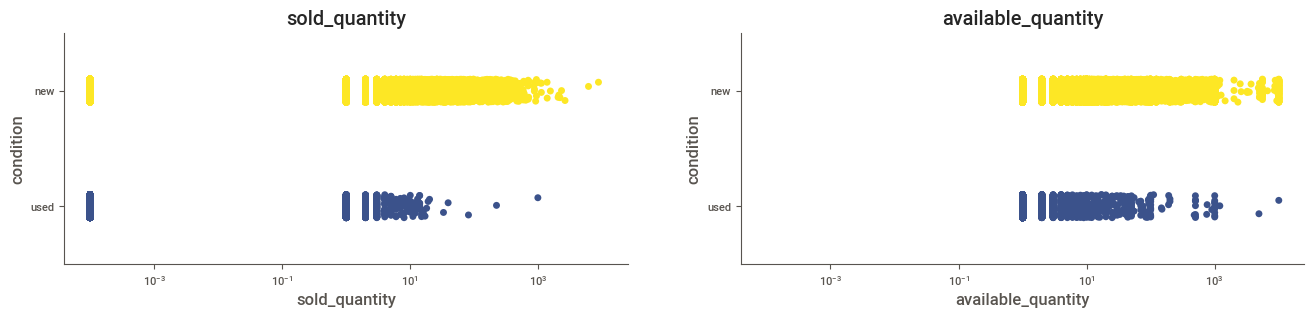

In [18]:
fig, axes = plt.subplots(1, len(qtd_cols), sharex=True, figsize=(16,3))

i = 0
for col in qtd_cols:
    # Add a small constant to ensure all values are positive and sufficiently far from zero
    data = df_silver[col] + 1e-4
    sns.stripplot(ax=axes[i], data = df_silver, y="condition", x=data, hue=df_silver["condition"], palette={"new":"#fde725", "used": "#3b528b"}, log_scale=True)
    axes[i].set_title(col)

    i += 1
    
sns.despine()
plt.show()

### **Categorical**
For the category plot, items with high cardinality still required preparation were excluded. For the remaining categories, the distributions tend to align with that of the overall population, with some noticeable deviations, such as "free" listings under listin_type_id, "me2" under shipping.mode, and "False" under flag_warranty. 

#### Flag

In [19]:
def convert_to_flag(df, cols_list):
    for col in cols_list:
        df[f'flag_{col}'] = df[col].where(df[col].isnull(), False).fillna(True)
        df = df.drop(col, axis=1)
    return df

df_gold = convert_to_flag(df_silver, ["warranty"])

# update categorical list
categorical = [col for col in categorical if col in df_gold.columns] + ["flag_warranty"]
print(categorical)

['condition', 'listing_type_id', 'buying_mode', 'currency_id', 'status', 'seller_address.state.name', 'shipping.mode', 'category_id', 'seller_id', 'seller_address.city.name', 'flag_warranty']


#### Cardinality reduction
The reduction in variable cardinality followed the principles of Pareto and performance. Further analysis may allow for different utilization of the two variables with performance-based reduction.

In [20]:
def cardinality(data, params_cardinality):

    # data and params
    df = data
    params = params_cardinality

    # import objetcs
    for col in params.keys():
        column = col
        threshold = params[col]["threshold"]
        others_label = params[col]["others_label"]

        # create Pareto's list
        df_pareto = df.groupby(column)[[column]].count().rename(
            columns={column: "count"}).reset_index()
        df_pareto = df_pareto.sort_values(by='count', ascending=False)
        df_pareto["cumpercentage"] = df_pareto["count"].cumsum() / \
            df_pareto["count"].sum() * 100
        pareto_list = df_pareto.loc[df_pareto["cumpercentage"]
                                    < threshold][column].unique()

        # replace labels
        for label in pareto_list:
            df.loc[df[column] == label, (column)] = label
        df[column] = np.where(
            df[column].isin(pareto_list), df[column], others_label)

    return df

params_cardinality = {
    "category_id": {
        "threshold": 81,
        "others_label": "other_category",
    },
    "seller_id": {
        "threshold": 40,
        "others_label": "other_seller",
    },
    "seller_address.city.name": {
        "threshold": 50,
        "others_label": "other_city",
    },
}

df_gold = cardinality(data=df_gold, params_cardinality=params_cardinality)

In [21]:
cardinality = ["category_id", "seller_id", "seller_address.city.name"]
data = []
for col in cardinality:
    qtd_old = len(df_silver[col].unique())
    qtd_new = len(df_gold[col].unique())
    data.append(tuple([qtd_old, qtd_new]))

pd.DataFrame(data=data, columns=["Qtd Labels Original", "Qtd Labels New"])

,Qtd Labels Original,Qtd Labels New
0,10907,2607
1,35915,1111
2,3656,36


#### Distributions

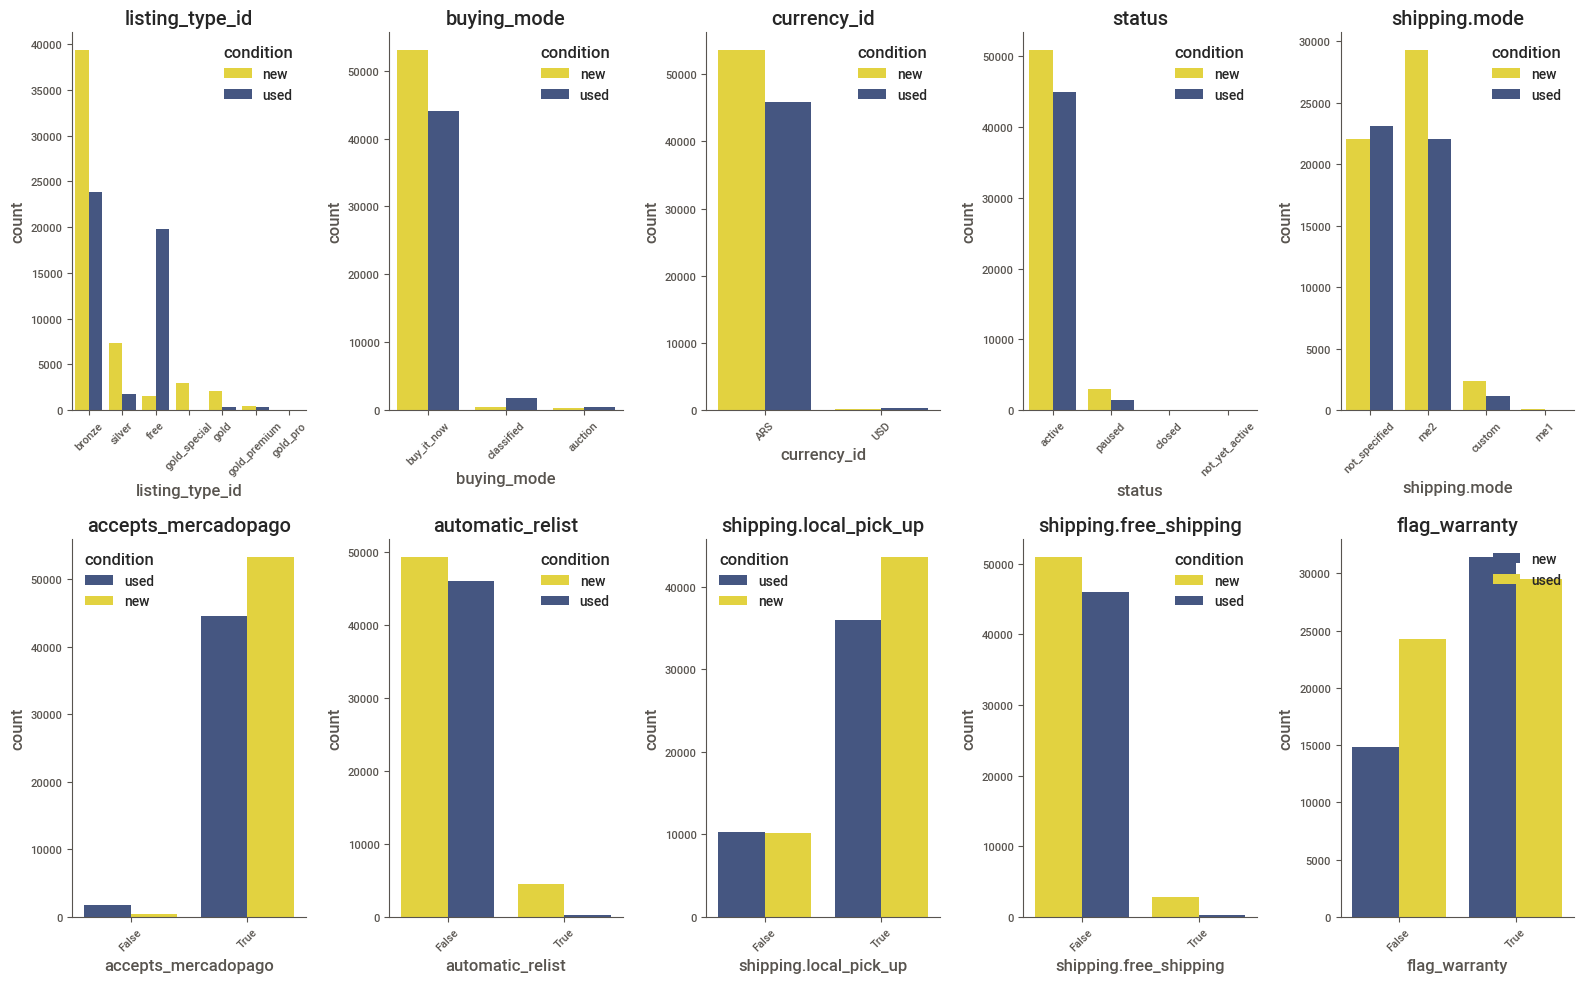

In [22]:
cat_plot = [
    "listing_type_id",
    "buying_mode",
    "currency_id",
    "status",
    "shipping.mode","accepts_mercadopago",
    "automatic_relist",
    "shipping.local_pick_up",
    "shipping.free_shipping",
    "flag_warranty",
]

fig, axes = plt.subplots(2, 5, figsize=(16,10))

i = 0
for col in cat_plot:
    sns.countplot(x=col, hue="condition", palette={"new":"#fde725", "used": "#3b528b"}, data=df_gold, ax=axes[i//5, i%5])
    axes[i//5, i%5].set_title(col)
    axes[i//5, i%5].tick_params(axis='x', rotation=45)
    i += 1
    
sns.despine()
plt.tight_layout()
plt.legend(labels=["new", "used"], loc="upper right") 
plt.show()

## **Model**

The model development process followed several key steps:

1. Data capture and base division were performed using a script in the .py file.
2. A preprocessing pipeline, separate from the model, was created for AutoML and optimization studies.
3. The AutoML study was used to understand the performance of different approaches. Preprocessing and hyperparameter engineering were done in the pipeline, not in the experiment.
4. Three different optimization processes were tested: grid search, random search, and Bayesian optimization. Bayesian optimization, which considers prior results, was chosen for its ability to customize test parameters, among other reasons.
5. A single pipeline was created with the defined hyperparameters, incorporating preprocessing and the model.
6. Predictions and performance metrics were presented according to the briefing. It's important to note that due to the absence of a seed in the creation of the training and test bases, the results may vary slightly from what is presented. However, the AutoML and hyperparameter optimization experiments were conducted using cross-validation techniques and with the isolated test base (used only for prediction).
<br>
<br>
<img src="https://i.ibb.co/RYb129W/flow.png" alt="flow" width="800"/>
<br><br>
<i>Get data > Split data > Preprocess > AutoML experiment > Hyperparameter Optimization > Model > Train & Test > Score</i>

### **Get Data**

In [23]:
def build_dataset():
    data = [json.loads(x) for x in open("MLA_100k_checked_v3.jsonlines")]
    def target(x): return x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

### **Train & Test Split**

In [24]:
# Train and test data following sklearn naming conventions
# X_train (X_test too) is a list of dicts with information about each item.
# y_train (y_test too) contains the labels to be predicted (new or used).
# The label of X_train[i] is y_train[i].
# The label of X_test[i] is y_test[i].
X_train, y_train, X_test, y_test = build_dataset()

### **Preprocessing**

Custom classes developed for this pipeline:
- ColumnSelector
- TypeTransformer
- CustomImputer
- FlagTransformer
- CardinalityTransformer

In [25]:
# JsonNormalizer
class JsonNormalizer(BaseEstimator, TransformerMixin):
    """
    Transformer that normalizes a list of dictionaries into a pandas DataFrame.
    """

    def __init__(self):
        """
        Initialize the JsonNormalizer.
        """
        pass

    def fit(self, X, y=None):
        """
        Fit the transformer.

        Parameters:
        X (array-like): Input data.
        y (array-like, optional): Target values (ignored).

        Returns:
        self: The fitted transformer.
        """
        return self

    def transform(self, X):
        """
        Transform the input data by normalizing JSON.

        Parameters:
        X (array-like): Input data.

        Returns:
        pandas.DataFrame: Transformed DataFrame.
        """
        X_df = pd.json_normalize(X)
        return X_df

# Column Selector Class

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer that selects specified columns from a DataFrame.
    """

    def __init__(self, columns):
        """
        Initialize the ColumnSelector.

        Parameters:
        columns (list of str): List of columns to select.
        """
        self.columns = columns

    def fit(self, X, y=None):
        """
        Fit the transformer.

        Parameters:
        X (pandas.DataFrame): Input data.
        y (array-like, optional): Target values (ignored).

        Returns:
        self: The fitted transformer.
        """
        return self

    def transform(self, X):
        """
        Transform the input data by selecting specified columns.

        Parameters:
        X (pandas.DataFrame): Input data.

        Returns:
        pandas.DataFrame: DataFrame with selected columns.
        """
        return X[self.columns]

# Type Transformer Class

class TypeTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer that converts all columns in a DataFrame to a specified data type.
    """

    def __init__(self, type="object"):
        """
        Initialize the TypeTransformer.

        Parameters:
        type (str): The type to convert columns to. Default is "object".
        """
        self.type = type

    def fit(self, X, y=None):
        """
        Fit the transformer.

        Parameters:
        X (pandas.DataFrame): Input data.
        y (array-like, optional): Target values (ignored).

        Returns:
        self: The fitted transformer.
        """
        return self

    def transform(self, X):
        """
        Transform the input data by converting columns to the specified type.

        Parameters:
        X (pandas.DataFrame): Input data.

        Returns:
        pandas.DataFrame: DataFrame with columns converted to the specified type.
        """
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X = X.astype(self.type)
        return X

# Custom Imputer Class (to output a dataframe)

class CustomImputer(BaseEstimator, TransformerMixin):
    """
    Transformer that imputes missing values and outputs a DataFrame.
    """

    def __init__(
            self,
            strategy='mean',
            missing_values=None,
            fill_value=None):
        """
        Initialize the CustomImputer.

        Parameters:
        strategy (str): The imputation strategy. Default is 'mean'.
        missing_values (scalar, str, np.nan, or None): The placeholder for the missing values. Default is None.
        fill_value (scalar, str, or None): The value to replace the missing values. Default is None.
        """
        self.strategy = strategy
        self.missing_values = missing_values
        self.fill_value = fill_value

    def fit(self, X, y=None):
        """
        Fit the imputer to the data.

        Parameters:
        X (pandas.DataFrame): Input data.
        y (array-like, optional): Target values (ignored).

        Returns:
        self: The fitted imputer.
        """
        self.imputer = SimpleImputer(
            strategy=self.strategy,
            missing_values=self.missing_values,
            fill_value=self.fill_value)
        self.imputer.fit(X)
        return self

    def transform(self, X):
        """
        Transform the input data by imputing missing values.

        Parameters:
        X (pandas.DataFrame): Input data.

        Returns:
        pandas.DataFrame: DataFrame with imputed values.
        """
        X_imputed = self.imputer.transform(X)
        X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)
        return X_imputed_df

# Flag Transformer Class

class FlagTransformer(BaseEstimator, TransformerMixin):
    """
    Convert specified columns into binary flags (1 if not null, 0 otherwise).

    Parameters:
    -----------
    flag_lst : list
        List of column names to be converted into binary flags.

    Methods:
    --------
    fit(self, X, y=None)
        Fit method required by scikit-learn's TransformerMixin. Returns self.

    transform(self, X)
        Transform method required by scikit-learn's TransformerMixin. 
        Converts specified columns into binary flags.

    Attributes:
    -----------
    flag_lst : list
        List of column names to be converted into binary flags.
    """

    def __init__(self, flag_lst):
        """
        Initialize the FlagTransformer instance.

        Parameters:
        -----------
        flag_lst : list
            List of column names to be converted into binary flags.
        """
        self.flag_lst = flag_lst

    def fit(self, X, y=None):
        """Fit method required by scikit-learn's TransformerMixin. 
        Returns self."""
        return self

    def transform(self, X):
        """Transform method required by scikit-learn's TransformerMixin. 
        Converts specified columns into binary flags."""
        return self.convert_to_flag(X)
    
    def convert_to_flag(self, X):
        """Convert specified columns into binary flags."""
        for col in self.flag_lst:
            X[col] = X[col].notnull().astype(int)
        return X

# Cardinality Reduction Class

class CardinalityTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer that reduces the cardinality of categorical features based on specified parameters.
    """

    def __init__(self, params):
        """
        Initialize the CardinalityTransformer.

        Parameters:
        params (dict): Dictionary of cardinality reduction parameters for specific columns.
        """
        self.params = params

    def fit(self, X, y=None):
        """
        Fit the transformer.

        Parameters:
        X (pandas.DataFrame or numpy.ndarray): Input data.
        y (array-like, optional): Target values (ignored).

        Returns:
        self: The fitted transformer.
        """
        return self

    def transform(self, X):
        """
        Transform the input data by reducing the cardinality of specified columns.

        Parameters:
        X (pandas.DataFrame or numpy.ndarray): Input data.

        Returns:
        pandas.DataFrame: DataFrame with reduced cardinality.
        """
        return self.cardinality(X)

    def cardinality(self, X):
        """
        Reduce the cardinality of the specified columns.

        Parameters:
        X (pandas.DataFrame or numpy.ndarray): Input data.

        Returns:
        pandas.DataFrame: DataFrame with reduced cardinality.
        """
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        params = self.params

        for col in params.keys():
            column = col
            method = params[col]["method"]
            threshold = params[col]["threshold"]
            others_label = params[col]["others_label"]

            x_pareto = X.groupby(column)[[column]].count().rename(
                columns={column: "count"}).reset_index()
            x_pareto = x_pareto.sort_values(by='count', ascending=False)
            x_pareto["cumpercentage"] = x_pareto["count"].cumsum(
            ) / x_pareto["count"].sum() * 100
            pareto_list = x_pareto.loc[x_pareto["cumpercentage"]
                                        < threshold][column].unique()

            if method == "equal":
                for label in pareto_list:
                    X.loc[X[column] == label, column] = label
                X[column] = np.where(
                    X[column].isin(pareto_list), X[column], others_label)

            elif method == "contains":
                labels_list = params[col]["labels_list"]
                for label in labels_list:
                    X.loc[X[column].str.contains(
                        label, case=False), column] = label
                X[column] = np.where(
                    X[column].isin(labels_list), X[column], others_label)

            X = pd.DataFrame(X)

        return X

supported_cols = [
    "warranty",
    "listing_type_id",
    "buying_mode",
    "currency_id",
    "status",
    "seller_address.state.name",
    "shipping.mode",
    "category_id",
    "seller_id",
    "seller_address.city.name",
    "price",
    "sold_quantity",
    "available_quantity",
    "accepts_mercadopago",
    "automatic_relist",
    "shipping.local_pick_up",
    "shipping.free_shipping",
]

categorical = [
    "listing_type_id",
    "buying_mode",
    "currency_id",
    "status",
    "seller_address.state.name",
    "shipping.mode",
    "category_id",
    "seller_id",
    "seller_address.city.name",
]

params = {
    "category_id": {
        "method": "equal",
        "threshold": 81,
        "others_label": "other_category",
    },
    "seller_id": {
        "method": "equal",
        "threshold": 40,
        "others_label": "other_seller",
    },
    "seller_address.city.name": {
        "method": "equal",
        "threshold": 50,
        "others_label": "other_city",
    },
}

numerical_standard_scaler = ['price']
numerical_min_max_scaler = ["sold_quantity", 'available_quantity']

flag_lst = ["warranty"]

boolean = [
    "warranty",
    "accepts_mercadopago",
    "automatic_relist",
    "shipping.local_pick_up",
    "shipping.free_shipping",
]

# CATEGORICAL FEATURES

categorical_imputers = []
categorical_imputers.append((
    "impute_most_frequent",
    SimpleImputer(strategy='most_frequent', missing_values=pd.NA),
    categorical
))

categorical_pipeline = Pipeline(steps=[
    ('string_transform', TypeTransformer(type='string')),
    ('imputer', CustomImputer(strategy='most_frequent')),
    ('cardinality', CardinalityTransformer(params)),
    ("target", TargetEncoder(target_type="binary")),
])

categorical_transformers = [
    ("categorical", categorical_pipeline, categorical)
]

# NUMERIC FEATURES

# Define the pipelines for each list of features
standard_scaler_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('standard_scaler', StandardScaler())
])

min_max_scaler_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('robust_scaler', RobustScaler())
])

# Combine the transformers using a ColumnTransformer
numerical_transformers = [
        ('num_standard_scaler', standard_scaler_transformer, numerical_standard_scaler),
        ('num_min_max_scaler', min_max_scaler_transformer, numerical_min_max_scaler)
    ]

# BOOL FEATURES

bool_imputers = []
bool_imputers.append((
    "impute_most_frequent",
    SimpleImputer(strategy='most_frequent', missing_values=pd.NA,),
    boolean
))

bool_pipeline = Pipeline(steps=[
    ('string_transform', TypeTransformer(type='string')),
    ('flag', FlagTransformer(flag_lst)),
    ("imputer", ColumnTransformer(bool_imputers, remainder='passthrough')),
    ("encoder", OrdinalEncoder()),
])

bool_transformers = [("boolean", bool_pipeline, boolean)]

# PIPELINE

column_selector = ColumnSelector(columns=supported_cols)
transformers = categorical_transformers + \
    numerical_transformers + bool_transformers
preprocessor = ColumnTransformer(transformers, remainder="passthrough")

preprocess_pipeline = Pipeline([
    ("json_normalizer", JsonNormalizer()),
    ("column_selector", column_selector),
    ("preprocessor", preprocessor),
])

set_config(display="diagram")
preprocess_pipeline

Pipeline(steps=[('json_normalizer', JsonNormalizer()),
                ('column_selector',
                 ColumnSelector(columns=['warranty', 'listing_type_id',
                                         'buying_mode', 'currency_id', 'status',
                                         'seller_address.state.name',
                                         'shipping.mode', 'category_id',
                                         'seller_id',
                                         'seller_address.city.name', 'price',
                                         'sold_quantity', 'available_quantity',
                                         'accepts_mercadopago',
                                         'automatic_relist',
                                         'ship...
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('impute_most_frequent',
                                                                                                    SimpleImputer(missing_values=<NA>,
                                                                                                                  strategy='most_frequent'),
                                                                                                    ['warranty',
                                                                                                     'accepts_mercadopago',
                                                                                                     'automatic_relist',
                                                                                                     'shipping.local_pick_up',
                                                                                                     'shipping.free_shipping'])])),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['warranty',
                                                   'accepts_mercadopago',
                                                   'automatic_relist',
                                                   'shipping.local_pick_up',
                                                   'shipping.free_shipping'])]))])

### **AutoML Experiment**

By PyCaret

Decision trees performed slightly better than other approaches, with the XGBoost ensemble model emerging as the winner (accuracy > 0.90).

In [26]:
# PREPROCESS

label_encoder = LabelEncoder()
y_processed = label_encoder.fit_transform(y_train)

preprocess_pipeline.fit(X_train, y_processed)
X_preprocessed = preprocess_pipeline.transform(X_train)

In [27]:
# init setup
clf = setup(
    X_preprocessed, 
    target = y_processed,
    preprocess = False,
    log_experiment=True,
    experiment_name='codex',
    train_size=0.8,
    )

# compare models
best = compare_models()

,Description,Value
0,Session id,7886
1,Target,target
2,Target type,Binary
3,Original data shape,"(90000, 18)"
4,Transformed data shape,"(90000, 18)"
5,Transformed train set shape,"(72000, 18)"
6,Transformed test set shape,"(18000, 18)"
7,Numeric features,17


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9047,0.9705,0.9063,0.8898,0.8979,0.8085,0.8087,0.1570
lightgbm,Light Gradient Boosting Machine,0.9022,0.9702,0.9120,0.8809,0.8962,0.8038,0.8042,0.2590
gbc,Gradient Boosting Classifier,0.8996,0.9681,0.8898,0.8929,0.8913,0.7980,0.7980,0.9450
rf,Random Forest Classifier,0.8992,0.9647,0.8974,0.8862,0.8917,0.7974,0.7975,0.8500
ada,Ada Boost Classifier,0.8944,0.9650,0.8786,0.8916,0.8850,0.7874,0.7875,0.3150
et,Extra Trees Classifier,0.8940,0.9548,0.8883,0.8834,0.8858,0.7870,0.7870,0.8650
lr,Logistic Regression,0.8902,0.9605,0.8749,0.8864,0.8806,0.7790,0.7791,0.7020
svm,SVM - Linear Kernel,0.8893,0.9598,0.8745,0.8855,0.8796,0.7771,0.7777,0.0470
ridge,Ridge Classifier,0.8890,0.9586,0.8680,0.8894,0.8786,0.7763,0.7765,0.0290
lda,Linear Discriminant Analysis,0.8890,0.9586,0.8680,0.8894,0.8786,0.7764,0.7766,0.0330


In [28]:
best.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': 'cpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 7886,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

### **Optimization**

#### Bayesian optimization

In [29]:
from hyperopt import fmin, tpe, hp, STATUS_OK
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import numpy as np

# hyperparameter space
space = {
    'max_depth': hp.quniform('max_depth', 2.0, 10.0, 1.0),
    'learning_rate': hp.loguniform('learning_rate', -7, -3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
}

np.seterr(under='ignore')

# objective function to minimize
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params["eval_metric"] = ["auc"]
    xgb_model = XGBClassifier(**params)
    xgb_model.fit(X_preprocessed, y_processed)
    y_pred = xgb_model.predict(X_preprocessed)
    score = roc_auc_score(y_processed, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# run
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [01:05<00:00,  1.53trial/s, best loss: -0.9097200191615693]
Best set of hyperparameters:  {'learning_rate': 0.049462279298388846, 'max_depth': 10.0, 'n_estimators': 143.0, 'subsample': 0.7677084973211453}


### **Model**

In [32]:
# MODEL

space = {
    'learning_rate': 0.049462279298388846,
    'max_depth': 10,
    'n_estimators': 143,
    'subsample': 0.7677084973211453
}

# XGBClassifier with the parameters from the space dictionary
xgbc_classifier = XGBClassifier(**space)

model = Pipeline([
    ("json_normalizer", JsonNormalizer()),
    ("column_selector", column_selector),
    ("preprocessor", preprocessor),
    ("classifier", xgbc_classifier),
])

set_config(display="diagram")
model

Pipeline(memory=None,
         steps=[('json_normalizer', JsonNormalizer()),
                ('column_selector',
                 ColumnSelector(columns=['warranty', 'listing_type_id',
                                         'buying_mode', 'currency_id', 'status',
                                         'seller_address.state.name',
                                         'shipping.mode', 'category_id',
                                         'seller_id',
                                         'seller_address.city.name', 'price',
                                         'sold_quantity', 'available_quantity',
                                         'accepts_mercadopago',
                                         'automatic_r...
                               interaction_constraints=None,
                               learning_rate=0.049462279298388846, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=143,
                               n_jobs=None, num_parallel_tree=None,
                               objective='binary:logistic', ...))],
         verbose=False)

### **Training**

In [33]:
# TRAINING

model.fit(X_train, y_processed)

Pipeline(memory=None,
         steps=[('json_normalizer', JsonNormalizer()),
                ('column_selector',
                 ColumnSelector(columns=['warranty', 'listing_type_id',
                                         'buying_mode', 'currency_id', 'status',
                                         'seller_address.state.name',
                                         'shipping.mode', 'category_id',
                                         'seller_id',
                                         'seller_address.city.name', 'price',
                                         'sold_quantity', 'available_quantity',
                                         'accepts_mercadopago',
                                         'automatic_r...
                               interaction_constraints=None,
                               learning_rate=0.049462279298388846, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=143,
                               n_jobs=None, num_parallel_tree=None,
                               objective='binary:logistic', ...))],
         verbose=False)

### **Test & Score**
The model demonstrated results above 89% in all experiments, showing consistency between the training, validation, and test results, with no indication of bias (overfitting).

In [34]:
# PREDICT

y_pred = model.predict(X_test)

# SCORE

y_test_processed = label_encoder.transform(y_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test_processed, y_pred)

# Print the accuracy
print(f"Accuracy: {np.round(accuracy, 4) * 100}%")

# Calculate the ROC AUC
roc_auc = roc_auc_score(y_test_processed, y_pred)

# Print the ROC AUC
print(f"ROC AUC: {np.round(roc_auc, 4) * 100}%")



Accuracy: 89.4%
ROC AUC: 89.38000000000001%


#### Plots

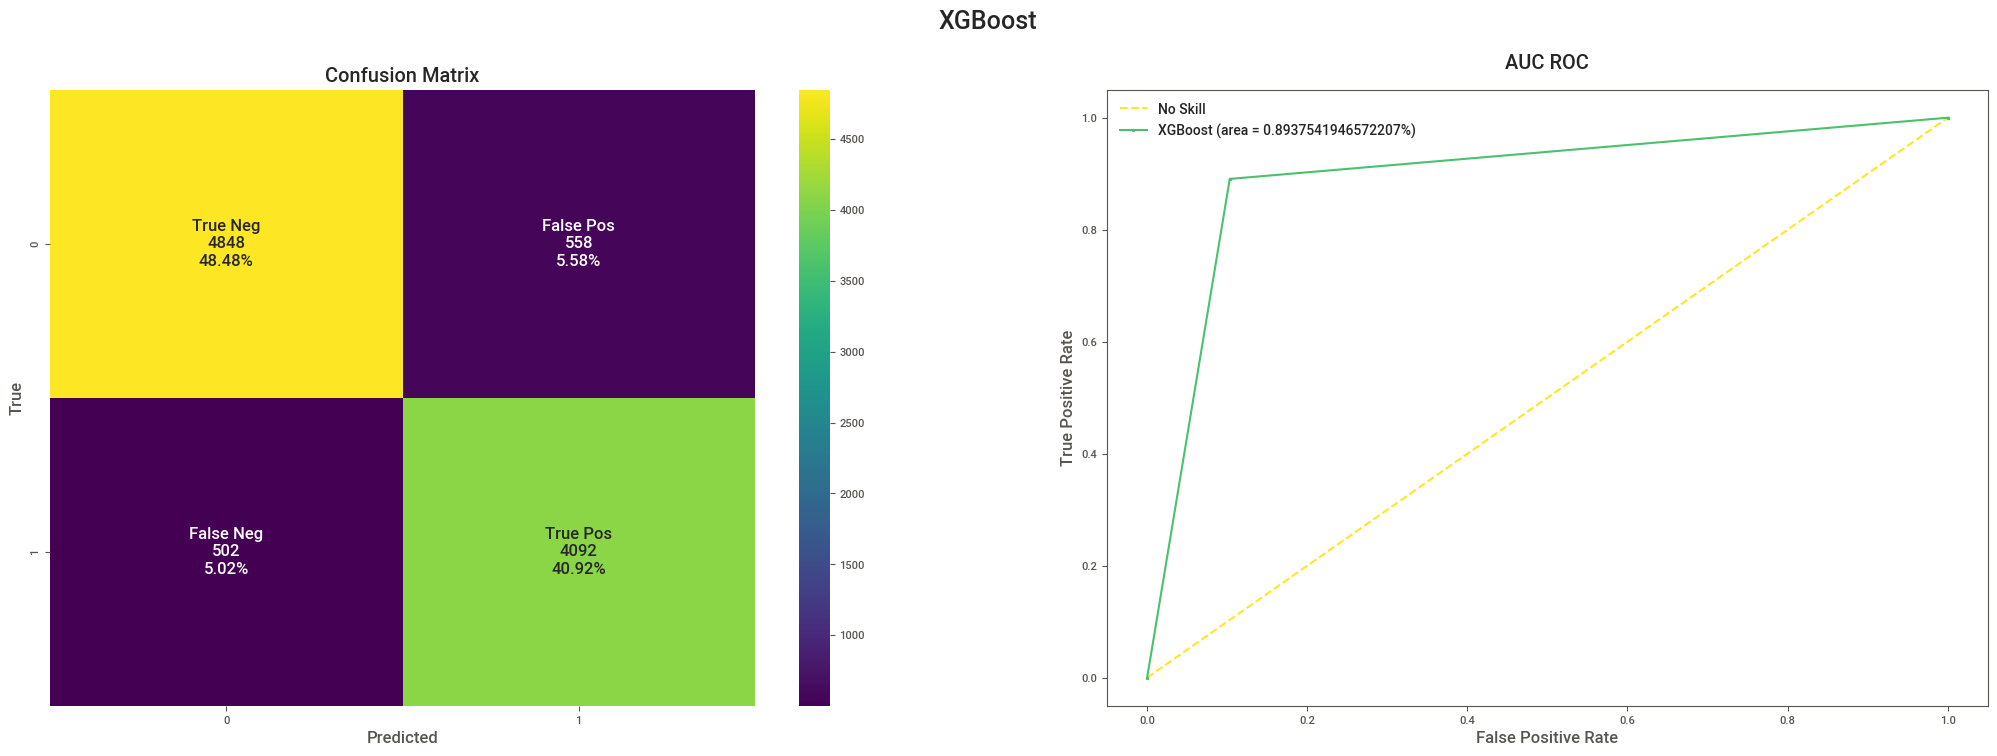

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw=({'hspace':0.5}))
fig.suptitle('XGBoost', fontsize=18, weight='semibold', y=0.98)
pad = 15

# CONFUSION MATRIX

cnf_matrix = confusion_matrix(y_test_processed, y_pred)
plt.subplot(1, 2, 1)

labels = [0, 1]
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cnf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# create the heatmap
ax = sns.heatmap(data=pd.DataFrame(cnf_matrix), annot=labels, cmap="viridis", fmt='')
ax.xaxis.set_label_position("bottom")
ax.set_title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted');

# AUC ROC

fpr, tpr, thresholds = roc_curve(y_test_processed, y_pred)

# plot the roc curve
plt.subplot(1, 2, 2)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill', color='#fde725')
plt.plot(fpr, tpr,  color='#4ac16d', marker='.', label='XGBoost (area = {}%)'.format(roc_auc))

# axis labels
plt.title('AUC ROC', pad=pad)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

## **Conclusion & Improvements**
The developed model has surpassed the performance criteria **(accuracy > 89%)**, showing consistency and no apparent biases. However, there are opportunities for **improvements** that need to be explored. I want to emphasize two specific points:
1. Creating **outlier flags** for the numerical features.
2. To add **new features** to the model, investigate the relationship between the inside values of the **list-type features** and the target variable (correlation and association, for example). This can be done by exploding the variables, pivoting each one, and concatenating them with the target.

# **Thank you!**

---